In [1]:
#!/bin/python3
import csv, random, argparse
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import random_split
from gensim.models import KeyedVectors
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
import string
import re
#NonComplasory Module
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set()

In [2]:
class imdb_HAN_dataset(Dataset):
    def __init__(self,path,num_sntnc,num_word,embad_model,embedlen):
        self.data_frame=pd.read_csv(path,)
        self.model=embad_model
        self.sen_per_review=num_sntnc
        self.word_per_sen=num_word
        self.embedlen=embedlen
        remove_char='"#$%&\'()*+-/:;<=>@[\\]^_`{|}~'
        self.table = str.maketrans('', '',remove_char)
#         if 'zz' in self.word_count:
#             self.word_count['zz']+=len(self)*self.h-self.total_word
#         else:
#             self.word_count['zz']=len(self)*self.h-self.total_word
#         self.total_word=len(self)*self.h
        
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        return {'review':self.data_dict[idx]['review'],'rating':self.data_dict[idx]['rating']}
    
    def init_vocab(self):
        self.vocab,self.not_invocab,self.word_count,self.total_word = self.get_vacabulary()
    
    def init_vocab_with_dataset(self,data_set):
        self.vocab,self.not_invocab,self.word_count,self.total_word = \
        data_set.vocab,data_set.not_invocab,data_set.word_count,data_set.total_word
    
    def init_data_dict(self):
        self.data_dict=self.build_data_dict_fixed_dim()
        
    def init_data_dict_with_dataset(self,data_set):
        self.data_dict=data_set.data_dict
    
    def init_vocab_embed(self):
        self.vocabmat=torch.rand(self.embedlen,len(self.vocab)+1)
        self.indtoword={}
        self.wordtoind={}
        for i,w in enumerate(self.vocab):
            self.vocabmat[:,i]=torch.tensor(self.model[w]/np.linalg.norm(self.model[w]),device=device)
            self.indtoword[i]=w
            self.wordtoind[w]=i
        self.indtoword[len(self.vocab)]='PADD_NULL'
        self.wordtoind['PADD_NULL']=int(len(self.vocab))
        self.vocabmat[:,len(self.vocab)]=torch.tensor(self.model['za']*0)   
        
    def init_vocab_embed_with_dataset(self,data_set):
        self.vocabmat=data_set.vocabmat
        self.indtoword=data_set.indtoword
        self.wordtoind=data_set.wordtoind
        
    def init_vocab_parameter(self):#order of initializasation matters here
        self.init_vocab()
        self.init_vocab_embed()
        self.init_data_dict()
        
    def init_vocab_parameter_with_dataset(self,data_set):
        self.init_vocab_with_dataset(data_set)
        self.init_vocab_embed_with_dataset(data_set)
        self.init_data_dict_with_dataset(data_set)
        
    def get_vacabulary(self):
        vocab=set()
        not_invocab=set()
        word_count={}
        word_count['za']=0
        total_word=0
        for i in range(len(self)):
            pp1=re.findall('\[.*?\]',self.data_frame.loc[i]['review'],re.I)#regex '\[.*?\]' {? is used for non greedy choice, produce result by consumming minimum charcter}
            for sen in pp1:
                pp2=re.findall('(\".+?\")+',sen)
                for w in pp2:
                    w=w[1:-1]
                    w1=str.lower(w.translate(self.table))
                    if w1 in self.model.vocab:
                        vocab.add(w1)
                        if w1 in word_count:
                            word_count[w1]+=1
                        else:
                            word_count[w1]=1
                    else:
                        not_invocab.add(w1)
                        word_count['za']+=1
                    total_word+=1
        return vocab,not_invocab,word_count,total_word
    
    def build_data_dict(self):
        data_dict={}
        for idx in range(len(self)):
            element={}
            review=[]
            label=0
            pp1=re.findall('\[.*?\]',self.data_frame.loc[idx]['review'],re.I)#regex '\[.*?\]' {? is used for non greedy choice, produce result by consumming minimum charcter}
            for i,sen in enumerate(pp1):
                temp_l=[]
                pp2=re.findall('(\".+?\")+',sen)
                for j,w in enumerate(pp2):
                    w=w[1:-1]
                    w1=str.lower(w.translate(self.table))
                    if w1 in self.model.vocab:
                        temp_l.append(self.wordtoind[w1])
                    else:
                        if(w1=="n't"):
                            temp_l.append(self.wordtoind['not'])
                        elif(w1=="'ve"):
                            temp_l.append(self.wordtoind['have'])
                        elif(w1=="'re"):
                            temp_l.append(self.wordtoind['are'])
                        elif(w1=="wo"):
                            temp_l.append(self.wordtoind['will'])
                        else:
                            temp_l.append(self.wordtoind['za'])
                review.append(temp_l)
            if self.data_frame.loc[idx][1]=='pos':
                label=1
            else:
                label=0
            element['review']=review
            element['rating']=label
            data_dict[idx]=element
        return data_dict
    
    def build_data_dict_fixed_dim(self):
        data_dict={}
        for idx in range(len(self)):
            element={}
            X=torch.zeros(self.sen_per_review,self.word_per_sen,dtype=torch.long) 
            label=0
            pp1=re.findall('\[.*?\]',self.data_frame.loc[idx]['review'],re.I)#regex '\[.*?\]' {? is used for non greedy choice, produce result by consumming minimum charcter}
            for i,sen in enumerate(pp1):
                if i >=self.sen_per_review:
                    break
                pp2=re.findall('(\".+?\")+',sen)
                for j,w in enumerate(pp2):
                    if j >=self.word_per_sen-1:
                        break
                    w=w[1:-1]
                    w1=str.lower(w.translate(self.table))
                    if w1 in self.model.vocab:
                        X[i][j]=self.wordtoind[w1]
                    else:
                        if(w1=="n't"):
                            X[i][j]=self.wordtoind['not']
                        elif(w1=="'ve"):
                            X[i][j]=self.wordtoind['have']
                        elif(w1=="'re"):
                            X[i][j]=self.wordtoind['are']
                        elif(w1=="wo"):
                            X[i][j]=self.wordtoind['will']
                        else:
                            X[i][j]=self.wordtoind['za']
                lj=j
                if(lj<=self.word_per_sen-1):
                    X[i][lj]=self.wordtoind['.']
                    lj+=1
                    while(lj<self.word_per_sen):
                        X[i][lj]=self.wordtoind['PADD_NULL']
                        lj+=1
            li=i
            while(li<self.sen_per_review):
                for j in range(self.word_per_sen):
                    X[li][j]=self.wordtoind['PADD_NULL']
                li+=1

            if self.data_frame.loc[idx][1]=='pos':
                label=1
            else:
                label=0
            element['review']=X
            element['rating']=label
            data_dict[idx]=element
        return data_dict


In [3]:
def data_stats(df):    
    word_len=[]
    sen_count=[]
    word_count=[]
    for i in range(len(df)):
        pp1=re.findall('\[.*?\]',df.loc[i]['review'],re.I)
        sen_count.append(len(pp1))
        for j in range(len(pp1)):
            pp2=re.findall('(\".+?\")+',pp1[j])
            word_count.append(len(pp2))
            for k in range(len(pp2)):
                word_len.append(len(pp2[k])-2)

    # plt.subplot(211)
    p_value=90
    plt.title("word_per_sentence plot, total sentence="+str(len(word_count)))
    plt.plot(word_count)
    plt.figtext(.35,.75,str(p_value)+"_percentile ="+str(np.percentile(word_count,p_value)))
    plt.show()
    plt.title("sentence_per_review plot, total Review="+str(len(sen_count)))
    # plt.subplot(221)
    plt.plot(sen_count)
    plt.title("sentence_per_review plot, total Review="+str(len(sen_count)))
    plt.figtext(.55,.75, str(p_value)+"percentile ="+str(np.percentile(sen_count,p_value)))
    plt.plot(sen_count)
    plt.show()

In [4]:
class HAN(nn.Module):
    def __init__(self,input_dim,hidden_dim):
        super(HAN,self).__init__()
        self.hidden_fsize=hidden_dim
        self.input_fsize=input_dim
        self.w_gru=nn.GRU(self.input_fsize,self.hidden_fsize,1,bidirectional=True,bias=False)
        self.w_fc=nn.Linear(self.hidden_fsize*2,self.hidden_fsize*2)
        self.w_context=nn.Parameter(torch.randn(self.hidden_fsize*2))
        self.s_gru=nn.GRU(self.hidden_fsize*2,self.hidden_fsize,1,bidirectional=True,bias=False)
        self.s_fc=nn.Linear(self.hidden_fsize*2,self.hidden_fsize*2)
        self.s_context=nn.Parameter(torch.randn(self.hidden_fsize*2))
        self.fc=nn.Linear(self.hidden_fsize*2,1)
        self.sigmoid=nn.Sigmoid()
    def init_wgru(self,gru,seqlen):
        optim.Adam(gru.parameters())
        i=0
        while(True):
            input = torch.zeros(seqlen,1000,gru.input_size,device=device)
            h0 = torch.zeros(2, 1000,gru.hidden_size,device=device)
            output, hn = gru(input, h0)
#             op_zero=torch.zeros(output.shape,device=device)
            loss=torch.sum(torch.abs(output))
            loss.backward()
            optimizer.step()
            if(i%100==0):
                print(loss.item())
            i+=1
            if(loss.item()<0.00001):
                break
    def init_embedding(self,pretrained):
        self.embed=nn.Embedding.from_pretrained(pretrained,freeze='False')
    def forward1(self,XD,S):#X.shape==Batch_size*num_sntnc*num_words
        #iterate over sentences one by one
        for i in range(XD.shape[1]):
            X1=XD[:,i,:]                      #ith sentence
            X=self.embed(X1)                 #embeding of sentence overBatch o/p X=batch_size*num_word*embed_dim
            X=torch.transpose(X,0,1)        #X=num_word*batch_size*embed_dim
            self.w_gru.flatten_parameters() #Reduce memory uses to explode
            wh,wfh=self.w_gru(X,torch.zeros(2,X.shape[1],X.shape[2]).to(device))#wh=num_word*batch_size*embed_dim
            wh=torch.transpose(wh,0,1)      #wh=(Batch_size*num_sntnc)*num_words*embed_dim
            alpha=torch.tanh(self.w_fc(wh)) # aplpha=(Batch_size*num_sntnc)*num_word*embed_dim importance vector per sentence
            w_attention=torch.matmul(alpha,self.w_context)#w_attention= (Batch_size*num_sntnc)*num_word
#             w_attention=torch.exp(w_attention)
#             total_attention=(1/torch.sum(w_attention,1))
#             w_attention=w_attention*total_attention.unsqueeze(1).expand_as(w_attention)
            w_attention=F.softmax(w_attention,dim=1)
            sntnci=torch.bmm(w_attention.unsqueeze(1),alpha)
            S[:,i,:]=sntnci.squeeze(1)
#             print('wh',wh.shape)
#             print('alpha',alpha.shape)
#             print('sntnci',sntnci.shape)
#             print('total_attention',total_attention.shape)
#             print('w_attention',w_attention.shape)
#             print('w_atention_sum',torch.sum(w_attention,1))

        S=torch.transpose(S,0,1)
        self.s_gru.flatten_parameters()
        sh,sfh=self.s_gru(S,torch.zeros(2,S.shape[1],self.hidden_fsize).to(device))
        sh=torch.transpose(sh,0,1)
        salpha=torch.tanh(self.s_fc(sh))
        s_attention=torch.matmul(salpha,self.s_context)
#         s_attention=torch.exp(s_attention)
#         total_sattention=(1/torch.sum(s_attention,1))
#         s_attention=s_attention*total_sattention.unsqueeze(1).expand_as(s_attention)
        s_attention=F.softmax(s_attention,dim=1)
        review=torch.bmm(s_attention.unsqueeze(1),salpha)
        op=self.fc(review.squeeze(1))
#         print('sh',sh.shape)
#         print('salpha',salpha.shape)
#         print('s_attention',s_attention.shape)
#         print('revivew',review.shape)
#         print('op',op.shape)
        return op,w_attention,s_attention

    def forward(self,XD):#X.shape==Batch_size*num_sntnc*num_words
            #iterate over sentences one by one
            X=XD.view(XD.shape[0]*XD.shape[1],XD.shape[2])
            X=self.embed(X)                 #embeding of sentence overBatch o/p X=batch_size*num_word*embed_dim
            X=torch.transpose(X,0,1)        #X=num_word*batch_size*embed_dim
#             self.w_gru.flatten_parameters() #Reduce memory uses to explode
            wh,wfh=self.w_gru(X,torch.zeros(2,X.shape[1],self.hidden_fsize).to(device))#wh=num_word*batch_size*embed_dim
            wh=torch.transpose(wh,0,1)      #wh=Batch_size*num_sntnc*num_words
            alpha=torch.tanh(self.w_fc(wh)) # aplpha=Batch_size*num_sntnc*embed_dim importance vector per sentence
            w_attention=torch.matmul(alpha,self.w_context)#w_attention= Batch_size*num_sntnc
    #             w_attention=torch.exp(w_attention)
    #             total_attention=(1/torch.sum(w_attention,1))
    #             w_attention=w_attention*total_attention.unsqueeze(1).expand_as(w_attention)
            w_attention=F.softmax(w_attention,dim=1)
            S=torch.bmm(w_attention.unsqueeze(1),alpha)
            S=S.squeeze(1)
            S=S.view(XD.shape[0],XD.shape[1],S.shape[1])
    #             print('wh',wh.shape)
    #             print('alpha',alpha.shape)
    #             print('sntnci',sntnci.shape)
    #             print('total_attention',total_attention.shape)
    #             print('w_attention',w_attention.shape)
    #             print('w_atention_sum',torch.sum(w_attention,1))

            S=torch.transpose(S,0,1)
#             self.s_gru.flatten_parameters()
            sh,sfh=self.s_gru(S,torch.zeros(2,S.shape[1],self.hidden_fsize).to(device))
            sh=torch.transpose(sh,0,1)
            salpha=torch.tanh(self.s_fc(sh))
            s_attention=torch.matmul(salpha,self.s_context)
    #         s_attention=torch.exp(s_attention)
    #         total_sattention=(1/torch.sum(s_attention,1))
    #         s_attention=s_attention*total_sattention.unsqueeze(1).expand_as(s_attention)
            s_attention=F.softmax(s_attention,dim=1)
            review=torch.bmm(s_attention.unsqueeze(1),salpha)
            op=self.fc(review.squeeze(1))
    #         print('sh',sh.shape)
    #         print('salpha',salpha.shape)
    #         print('s_attention',s_attention.shape)
    #         print('revivew',review.shape)
    #         print('op',op.shape)
            return op,w_attention,s_attention

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filename='glove.6B.50d.txt.word2vec'
model=KeyedVectors.load_word2vec_format(filename,binary=False)

In [6]:
tau=1
current=0
mb_size=500
total_doc=25000
channel=1
loss_ls=[]
valloss_ls=[]
train_acc=0
embedlen=50
num_sntnc=20
num_word=50
start = time.time()
# imdb_buffer=imdb_HAN_dataset('data/imdb-train.csv',num_sntnc,num_word,model,embedlen)
# imdb_buffer.init_vocab_parameter()

"""critical"""
#Be Remeber to read imdb_buffer newley if make changes in the imdb_HAN_dataset class
imdb_buffer1=torch.load('imdb_buffer_slen_20_wlen_50_new_preprocessed')
print ('It took', time.time()-start)

It took 2.5530967712402344


In [7]:
# torch.save(imdb_buffer,'imdb_buffer_slen_20_wlen_50_new_preprocessed')

In [8]:
# # indb_HAN_dataset Varifier Code
imdb=imdb_HAN_dataset('data/imdb-train.csv',num_sntnc,num_word,model,embedlen)
imdb.init_vocab_parameter_with_dataset(imdb_buffer1)
# a=imdb[0]['review']
# for k in a:
#     for k1 in k:
#         print(imdb.indtoword[int(k1)])

In [9]:
indices=list(range(len(imdb)))#list(range(len(imdb)))
random.shuffle(indices)
# train_sampler = SequentialSampler(indices[0:mb_size])
# val_sampler = SequentialSampler(indices[20000:250000])
train_sampler = SubsetRandomSampler(indices[0:20000])
val_sampler = SubsetRandomSampler(indices[20000:25000])
train_loader=DataLoader(imdb,batch_size=mb_size,num_workers=16,sampler=train_sampler)
valid_loader=DataLoader(imdb,batch_size=mb_size,num_workers=16,sampler=val_sampler)

han=HAN(imdb.embedlen,50)
han.init_embedding(imdb.vocabmat.t())
# han.w_gru.load_state_dict(torch.load('w_gru_init_wt'))
# han.s_gru.load_state_dict(torch.load('s_gru_init_wt'))

# if torch.cuda.device_count() > 1:
#     han=nn.DataParallel(han)
han.to(device=device)


criterion=nn.BCEWithLogitsLoss()
criterion.to(device)
loss_ls=[]

In [10]:
han

HAN(
  (w_gru): GRU(50, 50, bias=False, bidirectional=True)
  (w_fc): Linear(in_features=100, out_features=100, bias=True)
  (s_gru): GRU(100, 50, bias=False, bidirectional=True)
  (s_fc): Linear(in_features=100, out_features=100, bias=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (embed): Embedding(61003, 50)
)

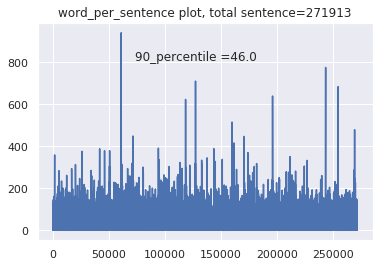

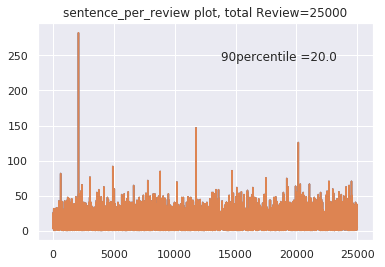

In [140]:
data_stats(imdb.data_frame)

In [65]:
optimizer = optim.Adam(han.parameters(),lr=.00005)    

print("preprocessing done")
#     trainer = IMDBClassifier(500,50)

preprocessing done


In [38]:
rnn = nn.GRU(10, 20, 2,bias=False)
input = torch.zeros(5, 3, 10)
h0 = torch.zeros(2, 3, 20)
output, hn = rnn(input, h0)
output

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

In [39]:
# #varifiear for embedding initialization
# for i in imdb[0]['review'][0]:
#     print(imdb.indtoword[i.item()])
#     print(han.embed(i.to(device=device)))
#     print(imdb.vocabmat[:,i.item()])

In [40]:
# # # # loss_ls=[]
# # # # valloss_ls=[]
# state=torch.load('save_han/han_20_50_train_85')
# han.load_state_dict(state['model'])
# optimizer.load_state_dict(state['optimizer'])

In [41]:
# import warnings
# warnings.filterwarnings('ignore')

In [72]:
mb['review'].shape
word_attention=w_a.view(500,20,50)

In [138]:
wat_gt_1=(word_attention>.05)

In [79]:
sat_gt_1=(s_a>.08)

In [100]:
sat_gt_1.shape

torch.Size([500, 20])

In [80]:
max_imp_ind=torch.argmax(word_attention,dim=2)

In [81]:
max_sen_ind=torch.argmax(s_a,dim=1)

In [70]:
for i in range(mb['review'].shape[0]):
    for j in range(mb['review'].shape[1]):
        for k in range(mb['review'].shape[2]):
            print('review:',imdb.indtoword[mb['review'][i,j,k].item()])
        for l in range(mb['review'].shape[2]):
            if(wat_gt_1[i,j,l].item()):
                print('most_important_word',imdb.indtoword[mb['review'][i,j,l].item()])
                

review: this
review: movie
review: is
review: awesome
review: .
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL
review: PADD_NULL


NameError: name 'wat_gt_1' is not defined

In [ ]:
color.w

In [155]:
for i in range(10,20):
    print("\033[1;34;40m \n\n\n\n-----------------REVIEW "+str(i)+"------------------")
    for j in range(mb['review'].shape[1]):
        if(sat_gt_1[i,j].item()):
            print("\033[1;33;40m \n\nSEN IMP:-",round(s_a[i,j].item(),3))
            for l in range(mb['review'].shape[2]):
                if(mb['review'][i,j,l].item()!=imdb.wordtoind['PADD_NULL']):
                    if(wat_gt_1[i,j,l].item()):
                        print("\033[0;31;44m "+str(imdb.indtoword[mb['review'][i,j,l].item()])+"{ "+str(round(word_attention[i,j,l].item(),3))+" }",end=' ')
                    else:
                        print("\033[0;33;44m",imdb.indtoword[mb['review'][i,j,l].item()],end=' ')
        else:
            print("\033[1;37;40m \n\nSEN IMP:-",round(s_a[i,j].item(),3))
            for l in range(mb['review'].shape[2]):
                if(mb['review'][i,j,l].item()!=imdb.wordtoind['PADD_NULL']):
                    if(wat_gt_1[i,j,l].item()):
                        print("\033[1;31;40m "+str(imdb.indtoword[mb['review'][i,j,l].item()])+"{ "+str(round(word_attention[i,j,l].item(),3))+" }",end=' ')
                    else:
                        print("\033[1;37;40m",imdb.indtoword[mb['review'][i,j,l].item()],end=' ')

 



-----------------REVIEW 10------------------
 

SEN IMP:- 0.347
 i  totally  agree  with  the  review  by  a  reviewer  of  variety  that  the  film  is  never{ 0.052 }  quite{ 0.183 }  as  funny{ 0.135 }  ,  lively{ 0.127 }  or  insightful  about  the  creative  process  as  its  premise  would  seem{ 0.071 }  to  warrant  .  

SEN IMP:- 0.202
 narratively  it  is  messy{ 0.457 }  and  the  lighting  is  really  problematic{ 0.225 }  .  

SEN IMP:- 0.246
 if{ 0.058 }  the  film  is  supposed{ 0.054 }  to  be  za  the  poor{ 0.17 }  lighting  does  nt  enhance  the  acting  and  it  is  sometimes{ 0.171 }  difficult{ 0.127 }  to  observe  the  facial  expressions  of  the  actors  .  

SEN IMP:- 0.031
 many{ 0.053 }  za  africans{ 0.06 }  will  have  difficulty  in  following  the  spoken  english  in  the  film  and  some{ 0.064 }  of  the  local  humor{ 0.083 }  will  be  lost{ 0.188 }  in  the  process  .  

SEN IMP:- 0.013
 i{ 0.242 }  watched{ 0.137 }  the  film  at  the  cap

In [ ]:
han.embed(mb['review'][0,0,11].to(device=device))

In [ ]:
imdb.indtoword[mb['review'][0,0,11].item()]

In [ ]:
for i in range(mb['review'].shape[0]):
    for j in range(mb['review'].shape[1]):
        for k in range(mb['review'].shape[2]):
            print(imdb.indtoword[mb['review'][i,j,k].item()])
        print('most_important_word',imdb.indtoword[mb['review'][i,j,max_imp_ind[i,j].item()].item()])

In [68]:
if True:
    print('Training...')
#     itrn=0
    num_itrn=150
    while(itrn<num_itrn):
        train_acc=0
        total_loss=0
        han.train()
        for numbatch,mb in enumerate(train_loader):
#             print(type(mb))
#             print(type(mb['review']))
#             print(mb['review'].shape)
            optimizer.zero_grad()
            X=mb['review'].to(device=device,dtype=torch.long)
            lbl=mb['rating'].to(device=device,dtype=torch.float)
            ylabel,w_a,s_a=han(X)
#             loss=-torch.mean(lbl*torch.log(.000001+torch.sigmoid(ylabel).reshape(lbl.shape))+(1-lbl)*torch.log(1.000001-torch.sigmoid(ylabel).reshape(lbl.shape)))
            loss=criterion(ylabel.view(lbl.shape),lbl)
            if(torch.isnan(loss).item()):
                break
            loss.backward()
            torch.nn.utils.clip_grad_norm_(han.parameters(),90)
            optimizer.step()
            total_loss=total_loss+loss.item()
            ylabel=torch.round(torch.sigmoid(ylabel))
            temp=torch.sum(ylabel.data.to(torch.long).reshape(lbl.shape)==lbl.data.to(torch.long))
            train_acc+=temp.item()
#             if(numbatch%10==0):
#                 print('whh_norm',han.module.w_gru.weight_hh_l0.norm().item())
#                 print('whh_max',han.module.w_gru.weight_hh_l0.max())
#                 print('whh_max_grad',han.module.w_gru.weight_hh_l0.grad.max())
#                 print('batch',numbatch)
#                 print('batch loss     :-',loss.item())
#                 print('batch accuracy :-',temp.item()/mb_size)
#                 print('X.shape',X.shape)
#             if(han.module.w_gru.weight_hh_l0.grad.max()>100):
#                 print("gradient expldes batch",numbatch)
#                 print("itrn",itrn)
#                 break

        if(torch.isnan(loss).item()):
                break
        han.eval()
        with torch.no_grad():
            val_acc=0
            val_loss=0
            for (num_val,val_dict) in enumerate(valid_loader):
                tb=val_dict['review'].to(device,dtype=torch.long) 
                tlbl=val_dict['rating'].to(device,dtype=torch.float)
                typred,vwa,vsa=han(tb)
#                 temp0=-torch.mean(tlbl*torch.log(.000001+torch.sigmoid(typred).reshape(tlbl.shape))+(1-tlbl)*torch.log(1.000001-torch.sigmoid(typred).reshape(tlbl.shape)))
                temp0=criterion(typred.view(tlbl.shape),tlbl)
                typred=torch.round(torch.sigmoid(typred))
#                 typred.round_()
                temp1=torch.sum(typred.data.reshape(tlbl.shape)==tlbl.data)
                val_acc+=temp1.item()
                val_loss=temp0.item()
            if(itrn%1==0):
                print("Training loss      :-",round(total_loss,3))
                print("Training Accuracy  :-",round(float(train_acc)/20000,3))
                print("Validation loss    :-",round(val_loss,3))
                print('Validation Accuracy:-',round(float(val_acc)/5000,3))
#                 for name, param in han.named_parameters():
#                     if param.requires_grad:
#                         print(name,param.grad[0])
#                         print(name,round(param.data.norm().item(),3))
                        
            loss_ls.append(total_loss)
            valloss_ls.append(val_loss)
        if(round(float(train_acc)/20000,3)>0.90):
            state={'model':han.state_dict(),'optimizer':optimizer.state_dict(),'m_itrn':itrn}
            torch.save(state,"save_han/"+"han_train_90_new_preprocessed"+str(itrn))
            break
        itrn+=1
        total_loss=0   
#     state={'model':adcnn.state_dict(),'optimizer':optimizer.state_dict(),'m_itrn':itrn}
#     torch.save(state,"current_imdb")
#Experiment Embeding Trainabale pretarined initialized both GRU bais=False 20 setence 50 word
print('Experiment Embeding Trainabale pretarined initialized both GRU bais=False 20 setence 50 word')

Training...
Training loss      :- 12.533
Training Accuracy  :- 0.862
Validation loss    :- 0.336
Validation Accuracy:- 0.84
Training loss      :- 12.515
Training Accuracy  :- 0.862
Validation loss    :- 0.385
Validation Accuracy:- 0.839
Training loss      :- 12.488
Training Accuracy  :- 0.862
Validation loss    :- 0.406
Validation Accuracy:- 0.84
Training loss      :- 12.49
Training Accuracy  :- 0.862
Validation loss    :- 0.371
Validation Accuracy:- 0.84
Training loss      :- 12.485
Training Accuracy  :- 0.862
Validation loss    :- 0.342
Validation Accuracy:- 0.839
Training loss      :- 12.463
Training Accuracy  :- 0.863
Validation loss    :- 0.324
Validation Accuracy:- 0.841
Training loss      :- 12.479
Training Accuracy  :- 0.863
Validation loss    :- 0.319
Validation Accuracy:- 0.841
Training loss      :- 12.46
Training Accuracy  :- 0.863
Validation loss    :- 0.385
Validation Accuracy:- 0.84
Training loss      :- 12.457
Training Accuracy  :- 0.862
Validation loss    :- 0.395
Valid

Process Process-4809:
Process Process-4802:
Process Process-4803:
Process Process-4813:
Process Process-4816:
Process Process-4811:
Process Process-4814:
Process Process-4806:
Process Process-4815:
Process Process-4808:
Process Process-4810:
Process Process-4812:
Process Process-4801:
Process Process-4807:
Process Process-4805:
Process Process-4804:
Traceback (most recent call last):
  File "/home/abhi/bap/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/abhi/bap/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/abhi/bap/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/abhi/bap/miniconda

KeyboardInterrupt: 

In [ ]:
if(round(float(train_acc)/20000,3)>0.85):
    print('yes')

In [ ]:
# print('whh_max_grad',han.module.w_gru.weight_hh_l0.grad.max())

In [ ]:
# han.module.w_gru.weight_hh_l0.grad.max()

In [ ]:
a=torch.Tensor([2])


In [ ]:
imdb.indtoword[1]


In [66]:
for name, param in han.named_parameters():
    if param.requires_grad:
        print(name,param.grad)
        print(name,round(param.data.norm().item(),3))
        

w_context tensor([ 0.0249,  0.0180,  0.0184,  0.0077,  0.0112, -0.0026,  0.0157, -0.0126,
         0.0055, -0.0101, -0.0233,  0.0207,  0.0165,  0.0117,  0.0249,  0.0196,
         0.0184,  0.0184, -0.0087, -0.0030, -0.0220,  0.0186,  0.0055,  0.0156,
         0.0024, -0.0199,  0.0040,  0.0038,  0.0168, -0.0111,  0.0069, -0.0123,
         0.0002,  0.0072,  0.0258, -0.0211, -0.0082, -0.0156, -0.0153, -0.0156,
         0.0132, -0.0260,  0.0202,  0.0215,  0.0297,  0.0130,  0.0073, -0.0135,
        -0.0175, -0.0007,  0.0067, -0.0204, -0.0134,  0.0237,  0.0046,  0.0219,
        -0.0007, -0.0144,  0.0060,  0.0248,  0.0193,  0.0031,  0.0084, -0.0184,
        -0.0178, -0.0230, -0.0196,  0.0175, -0.0005, -0.0034, -0.0252,  0.0040,
        -0.0126,  0.0113,  0.0013,  0.0181, -0.0029,  0.0045, -0.0081,  0.0185,
         0.0187,  0.0231,  0.0030, -0.0103, -0.0181, -0.0135, -0.0150,  0.0190,
         0.0237, -0.0049,  0.0237, -0.0098,  0.0106, -0.0214, -0.0107, -0.0129,
         0.0152,  0.0156,  0.0

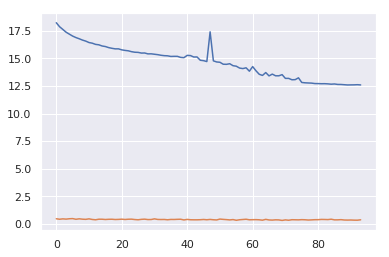

In [67]:
plt.plot(range(len(loss_ls)),loss_ls,range(len(valloss_ls)),valloss_ls)

In [69]:
state={'model':han.state_dict(),'optimizer':optimizer.state_dict(),'m_itrn':itrn}
torch.save(state,"save_han/"+"han_20_50_embed_glove_trainable_gru_bias_0_train_86")

In [ ]:
assert (typred >= 0. and typred <= 1.).all()

In [ ]:
class imdb_dataset_test(Dataset):
    def __init__(self,path,h,w,embad_model):
        self.data_frame=pd.read_csv(path,)
        self.model=embad_model
        self.h=h
        self.w=w
        self.table = str.maketrans('', '', string.punctuation)
        self.vocab,self.not_invocab,self.word_count,self.total_word=self.get_vacabulary()
        if 'zz' in self.word_count:
            self.word_count['zz']+=len(self)*self.h-self.total_word
        else:
            self.word_count['zz']=len(self)*self.h-self.total_word
        self.total_word=len(self)*self.h
        
        self.vocabmat=torch.rand(self.w,len(self.vocab),device=device)
        self.indtoword={}
        self.wordtoind={}
        for i,w in enumerate(self.vocab):
            self.vocabmat[:,i]=torch.tensor(self.model[w]/np.linalg.norm(self.model[w]),device=device)
            self.indtoword[i]=w
            self.wordtoind[w]=i
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        mat,label,word_weight,word_weight2=self.sen_to_mat(idx)
        return {'review':mat,'rating':label,"word_weight":word_weight,"word_weight2":word_weight2}
    
    def get_vacabulary(self):
        vocab=set()
        not_invocab=set()
        word_count={}
        word_count['za']=0
        total_word=0
        for i in range(len(self)):
            for j,w in enumerate((self.data_frame.loc[i][0]).split(' ')):
                w1=str.lower(w.translate(self.table))
                if w1 in self.model.vocab:
                    vocab.add(w1)
                    if w1 in word_count:
                        word_count[w1]+=1
                    else:
                        word_count[w1]=1
                else:
                    not_invocab.add(w1)
                    word_count['za']+=1
                total_word+=1
                if(j>=self.h-1):
                    break
        return vocab,not_invocab,word_count,total_word
    
    def sen_to_mat(self,idx):
        X=torch.zeros((self.h,self.w))
        word_weight=torch.ones(self.h)
        word_weight2=torch.ones(self.h)
        label=0
        for j,w in enumerate((self.data_frame.loc[idx][0]).split(' ')):
            w1=w.translate(self.table)
            w1=str.lower(w1)
            if w1 in self.model.vocab:
                b=self.model[w1]/np.linalg.norm(self.model[w1])
                X[j,:]=torch.Tensor(b).view(1,-1)
                word_weight[j]=1.0/self.word_count[w1]
                word_weight2[j]=np.exp(self.word_count[w1]*100/self.total_word)
            else:
                b=self.model['za']/np.linalg.norm(self.model['z'])
                X[j,:]=torch.Tensor(b).view(1,-1)
                word_weight[j]=1.0/self.word_count['za']
                word_weight2[j]=np.exp(self.word_count['za']*100/self.total_word)
            if(j>=self.h-1):
                break
        k=j
        b=self.model['zz']/np.linalg.norm(self.model['zz'])
        while(k<self.h):
            X[k,:]=torch.Tensor(b).view(1,-1)
            word_weight[j]=1.0/self.word_count['zz']
            word_weight2[j]=np.exp(self.word_count['zz']*100/self.total_word)
            k+=1

        if self.data_frame.loc[idx][1]=='pos':
            label=1
        else:
            label=0
        return X,label,word_weight,word_weight2


class ADCNN(torch.nn.Module):
    def __init__(self,in_c,out_c,doc_len,kernel_height,kernel_width):
        super(ADCNN,self).__init__()
        self.strd=int(kernel_height/2)
        self.h1=int((doc_len-kernel_height)/self.strd)+1
        self.h2=int((self.h1-kernel_height)/self.strd)+1
        self.h3=int((self.h2-kernel_height)/self.strd)+1
        self.conv1=nn.Conv2d(in_c,out_c,(kernel_height,kernel_width),stride=self.strd)
        self.conv2=nn.Conv2d(out_c,2*out_c,(kernel_height,1),stride=self.strd)
        self.conv2E=nn.Conv2d(2*out_c,2*out_c,(kernel_height,1),stride=self.strd)
        self.conv3=nn.Conv2d(2*out_c,2*out_c,(self.h3,1),stride=self.strd)
        self.dconv3=nn.ConvTranspose2d(2*out_c,2*out_c,(self.h3,1),stride=self.strd)
        self.dconv2E=nn.ConvTranspose2d(2*out_c,2*out_c,(kernel_height,1),stride=self.strd)
        self.dconv2=nn.ConvTranspose2d(2*out_c,out_c,(kernel_height,1),stride=self.strd)
        self.dconv1=nn.ConvTranspose2d(out_c,in_c,(kernel_height,kernel_width),stride=self.strd)
        self.fc1=nn.Linear(2*out_c,20)
        self.fc2=nn.Linear(20,1)
    def forward(self,x):
        x1=F.relu(self.conv1(x))
        x2=F.relu(self.conv2(x1))
        x2e=F.relu(self.conv2E(x2))
        x3=F.relu(self.conv3(x2e))
        x4=F.relu(self.dconv3(x3))
        x5=F.relu(self.dconv2E(x4,output_size=x2.size()))
        x6=F.relu(self.dconv2(x5,output_size=x1.size()))
        x7=self.dconv1(x6, output_size=x.size())
        f1=self.fc1(x3.view(x3.shape[0],-1))
        f2=self.fc2(F.dropout(torch.sigmoid_(f1),p=0.5))
        f2=torch.sigmoid_(F.dropout(f2,p=.3))
        return x7,x3,f2

if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--train', action='store_true')
#     parser.add_argument('--test', action='store_true')
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print("in main")
#     args = parser.parse_args()
    #code
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     filename='glove.6B.50d.txt.word2vec'
#     model=KeyedVectors.load_word2vec_format(filename,binary=False)
#     table = str.maketrans('', '', string.punctuation)
    
    height=100
    width=50
#     imdb=imdb_dataset('data/imdb-train.csv',height,width,model)
    
    tau=1
    current=0
    mb_size=80
    total_doc=25000
    channel=1
    loss_ls=[]
    valloss_ls=[]
    train_acc=0
    
    indices=list(range(len(imdb)))
    # np.random.shuffle(indices)
    train_sampler = SubsetRandomSampler(indices[0:20000])
    # train_sampler = SequentialSampler(indices[0:mb_size])
    val_sampler = SubsetRandomSampler(indices[20000:25000])
    # val_sampler = SequentialSampler(indices[20000:250000])
    train_loader=DataLoader(imdb,batch_size=mb_size,num_workers=16,sampler=train_sampler)
    valid_loader=DataLoader(imdb,batch_size=600,num_workers=16,sampler=val_sampler)

    adcnn=ADCNN(1,300,100,5,50)
    if torch.cuda.device_count() > 1:
        adcnn=nn.DataParallel(adcnn)
    adcnn.to(device=device)
    lbl_ls=[]
    optimizer = optim.Adam(adcnn.parameters(),lr=.01)    
    loss_ls=[]
    print("preprocessing done")
#     trainer = IMDBClassifier(500,50)
    if True:
        print('Training...')
        itrn=0
        num_itrn=1
        total_loss=0
        trained=torch.load("save_adcnn/"+"only_sent_139")
        adcnn.load_state_dict(trained['model'])
        optimizer.load_state_dict(trained['optimizer'])
        adcnn.train()
        while(itrn<num_itrn):
            train_acc=0
            for numbatch,mb in enumerate(train_loader):
                X=mb['review'].to(device=device)
                word_weight=mb['word_weight'].to(device=device)
                word_weight2=mb['word_weight2'].to(device=device)
                lbl=mb['rating'].to(device=device,dtype=torch.float)
                optimizer.zero_grad()
                ypred,encoded_X,ylabel=adcnn(X.unsqueeze_(1))
                ylabel=ylabel.to(device=device)

                ypred=ypred/torch.norm(ypred,2,3,keepdim=True)
                a=torch.matmul(ypred,imdb.vocabmat)*tau
                b=torch.exp(a)
                temp=torch.sum(b,3)
                c=torch.matmul(X.view(X.shape[0],1,height,1,width),ypred.view(ypred.shape[0],1,height,width,1))*tau
                temp1=torch.exp(c)
                d=torch.log(temp1.view(X.shape[0],1,height)/temp)
                e=word_weight*word_weight2
                loss0=-torch.sum(torch.matmul(d,e.unsqueeze_(2)))
                ls.append(lbl.item())

        #         loss=-torch.sum(d)/X.shape[0]*imdb.h
                loss1=-torch.dot(lbl,torch.log(ylabel.reshape(lbl.shape[0])))-torch.dot((1-lbl),torch.log((1-ylabel).reshape(lbl.shape[0])))

                loss=loss1/X.shape[0]
                loss.backward()
                optimizer.step()
                total_loss=total_loss+loss.item()
                ylabel.round_()
                temp=torch.sum(ylabel.data.reshape(lbl.shape)==lbl.data)
                train_acc+=temp.item()
        #         if(numbatch%10==0):
        #             print('batch',numbatch)
        # #             print('batch loss0 ',loss0.item())
        #             print('batch loss1 ',loss1.item())
        #             print('batch loss ',loss.item())

            adcnn.eval()
            with torch.no_grad():
                val_acc=0
                for (num_val,val_dict) in enumerate(valid_loader):
                    tb=val_dict['review'].to(device,dtype=torch.float)
                    tb.unsqueeze_(1)    
                    tlbl=val_dict['rating'].to(device,dtype=torch.float)
                    ex1,ex2,typred=adcnn(tb)
                    val_loss=-torch.dot(tlbl,torch.log2(typred.reshape(tlbl.shape[0])))-torch.dot((1-tlbl),torch.log2((1-typred).reshape(tlbl.shape[0])))
            #       val_loss=criterion(typred.reshape(tlbl.shape[0]),tlbl)
                    #loss=criterion(ypred,lbl)
                    typred.round_()
                    temp1=torch.sum(typred.data.reshape(tlbl.shape)==tlbl.data)
                    val_acc+=temp1.item()

                print("Training loss ",total_loss)
                print("Training Accuracy",float(train_acc)/20000)
                print("Validation loss ",val_loss)
                print('Validation Accuracy',float(val_acc)/5000)
#                 loss_ls.append(total_loss)
#                 valloss_ls.append(val_loss.item())
        #     if(itrn%20==9):
        #         state={'model':adcnn.state_dict(),'optimizer':optimizer.state_dict(),'m_itrn':itrn}
        #         torch.save(state,"save_adcnn/"+"rec_sent_"+str(itrn))
            itrn+=1
            total_loss=0   
        state={'model':adcnn.state_dict(),'optimizer':optimizer.state_dict(),'m_itrn':itrn}
        torch.save(state,"current_imdb")
    if False:
        print('Testing...')
        test_out_file = open('result/imdb-test.csv', 'w')
        test_writer = csv.writer(test_out_file, quoting=csv.QUOTE_ALL)
#         imdbt=imdb_dataset_test('data/imdb-test.csv',height,width,model)
        indices=range(len(imdbt))
        train_sampler = SequentialSampler(indices)
        train_loader=DataLoader(imdbt,batch_size=1,num_workers=8,sampler=train_sampler)
        df=pd.read_csv('data/imdb-test.csv')
        test_writer.writerow(['review', 'rating'])
        
        trained=torch.load("save_adcnn/"+"only_sent_139")
        adcnn.load_state_dict(trained['model'])
        optimizer.load_state_dict(trained['optimizer'])
        
        adcnn.eval()
        count=0
        for (num_batch,mb_dict) in enumerate(train_loader):
                mb=mb_dict['review'].to(device,dtype=torch.float)
                mb.unsqueeze_(1)
#                 lbl=mb_dict['rating'].to(device,dtype=torch.float)
                y,encoded_X,ypred=adcnn(mb)
                ypred.round_()
#                 print(int(ypred.item()))
                prediction = ['neg','pos']
                test_writer.writerow([df.loc[num_batch][0], prediction[int(ypred.item())]])
#         trainer.predict()
    print("end")

In [ ]:
print("end")

In [ ]:
print('Testing...')
test_out_file = open('result/imdb-test.csv', 'w')
test_writer = csv.writer(test_out_file, quoting=csv.QUOTE_ALL)
#         imdbt=imdb_dataset_test('data/imdb-test.csv',height,width,model)
indices=range(len(imdbt))
train_sampler = SequentialSampler(indices)
train_loader=DataLoader(imdbt,batch_size=1,num_workers=8,sampler=train_sampler)
df=pd.read_csv('data/w.csv')
test_writer.writerow(['review', 'rating'])

trained=torch.load("save_adcnn/"+"only_sent_139")
adcnn.load_state_dict(trained['model'])
optimizer.load_state_dict(trained['optimizer'])

adcnn.eval()
count=0
for (num_batch,mb_dict) in enumerate(train_loader):
    mb=mb_dict['review'].to(device,dtype=torch.float)
    mb.unsqueeze_(1)
#                 lbl=mb_dict['rating'].to(device,dtype=torch.float)
    y,encoded_X,ypred=adcnn(mb)
    ypred.round_()
#                 print(int(ypred.item()))
    prediction = ['neg','pos']
    for i in range(1000):
        test_writer.writerow([imdbt.data_frame.loc[num_batch*1000+i][0], prediction[int(ypred[i].item())]])
#         trainer.predict()

In [ ]:
# imdbt=imdb_dataset_test('data/w.csv',height,width,model)

In [ ]:
imdb=imdb_dataset('data/imdb-train.csv',height,width,model)
imdbt=imdb_dataset_test('data/imdb-test.csv',height,width,model)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
filename='glove.6B.50d.txt.word2vec'
model=KeyedVectors.load_word2vec_format(filename,binary=False)
table = str.maketrans('', '', string.punctuation)

In [ ]:
len(imdbtest)

In [ ]:
import torch
import numpy as np
import pandas as pd
import csv, random
from matplotlib import pyplot as plt
import seaborn as sbn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import random_split

from gensim.models import KeyedVectors
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
import string

sbn.set()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove/glove.6B.50d.txt'
word2vec_output_file = 'glove.6B.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
# aaaa?

filename='glove.6B.50d.txt.word2vec'
model=KeyedVectors.load_word2vec_format(filename,binary=False)
table = str.maketrans('', '', string.punctuation)
# stripped = [w.translate(table) for w in words]

In [ ]:
class imdb_dataset(Dataset):
    def __init__(self,path,h,w,embad_model):
        self.data_frame=pd.read_csv(path,)
        self.model=embad_model
        self.h=h
        self.w=w
        self.table = str.maketrans('', '', string.punctuation)
        self.vocab,self.not_invocab,self.word_count,self.total_word=self.get_vacabulary()
        if 'zz' in self.word_count:
            self.word_count['zz']+=len(self)*self.h-self.total_word
        else:
            self.word_count['zz']=len(self)*self.h-self.total_word
        self.total_word=len(self)*self.h
        
        self.vocabmat=torch.rand(self.w,len(self.vocab),device=device)
        self.indtoword={}
        self.wordtoind={}
        for i,w in enumerate(self.vocab):
            self.vocabmat[:,i]=torch.tensor(self.model[w]/np.linalg.norm(self.model[w]),device=device)
            self.indtoword[i]=w
            self.wordtoind[w]=i
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        mat,label,word_weight,word_weight2=self.sen_to_mat(idx)
        return {'review':mat,'rating':label,"word_weight":word_weight,"word_weight2":word_weight2}
    
    def get_vacabulary(self):
        vocab=set()
        not_invocab=set()
        word_count={}
        word_count['za']=0
        total_word=0
        for i in range(len(self)):
            for j,w in enumerate((self.data_frame.loc[i][0]).split(' ')):
                w1=str.lower(w.translate(self.table))
                if w1 in self.model.vocab:
                    vocab.add(w1)
                    if w1 in word_count:
                        word_count[w1]+=1
                    else:
                        word_count[w1]=1
                else:
                    not_invocab.add(w1)
                    word_count['za']+=1
                total_word+=1
                if(j>=self.h-1):
                    break
        return vocab,not_invocab,word_count,total_word
    
    def sen_to_mat(self,idx):
        X=torch.zeros((self.h,self.w))
        word_weight=torch.ones(self.h)
        word_weight2=torch.ones(self.h)
        label=0
        for j,w in enumerate((self.data_frame.loc[idx][0]).split(' ')):
            w1=w.translate(self.table)
            w1=str.lower(w1)
            if w1 in self.model.vocab:
                b=self.model[w1]/np.linalg.norm(self.model[w1])
                X[j,:]=torch.Tensor(b).view(1,-1)
                word_weight[j]=1.0/self.word_count[w1]
                word_weight2[j]=np.exp(self.word_count[w1]*100/self.total_word)
            else:
                b=self.model['za']/np.linalg.norm(self.model['z'])
                X[j,:]=torch.Tensor(b).view(1,-1)
                word_weight[j]=1.0/self.word_count['za']
                word_weight2[j]=np.exp(self.word_count['za']*100/self.total_word)
            if(j>=self.h-1):
                break
        k=j
        b=self.model['zz']/np.linalg.norm(self.model['zz'])
        while(k<self.h):
            X[k,:]=torch.Tensor(b).view(1,-1)
            word_weight[j]=1.0/self.word_count['zz']
            word_weight2[j]=np.exp(self.word_count['zz']*100/self.total_word)
            k+=1

        if self.data_frame.loc[idx][1]=='pos':
            label=1
        else:
            label=0
        return X,label,word_weight,word_weight2

In [ ]:
height=100
width=50
imdb=imdb_dataset('data/imdb-train.csv',height,width,model)

In [ ]:
# tau=0.01
current=0
mb_size=600
total_doc=25000
channel=1
loss_ls=[]
valloss_ls=[]
train_acc=0
# crt=nn.BCELoss()
# criterion=crt.to(device)

In [ ]:
indices=list(range(len(imdb)))
np.random.shuffle(indices)
train_sampler = SubsetRandomSampler(indices[0:1000])
# train_sampler = SequentialSampler(indices[0:mb_size])
val_sampler = SubsetRandomSampler(indices[20000:25000])
# val_sampler = SequentialSampler(indices[20000:250000])
train_loader=DataLoader(imdb,batch_size=mb_size,num_workers=8,sampler=train_sampler)
valid_loader=DataLoader(imdb,batch_size=500,num_workers=8,sampler=val_sampler)


In [ ]:
class ADCNN(torch.nn.Module):
    def __init__(self,in_c,out_c,doc_len,kernel_height,kernel_width):
        super(ADCNN,self).__init__()
        self.strd=int(kernel_height/2)
        self.h1=int((doc_len-kernel_height)/self.strd)+1
        self.h2=int((self.h1-kernel_height)/self.strd)+1
        self.h3=int((self.h2-kernel_height)/self.strd)+1
        self.conv1=nn.Conv2d(in_c,out_c,(kernel_height,kernel_width),stride=self.strd)
        self.conv2=nn.Conv2d(out_c,2*out_c,(kernel_height,1),stride=self.strd)
        self.conv2E=nn.Conv2d(2*out_c,2*out_c,(kernel_height,1),stride=self.strd)
        self.conv3=nn.Conv2d(2*out_c,2*out_c,(self.h3,1),stride=self.strd)
        self.dconv3=nn.ConvTranspose2d(2*out_c,2*out_c,(self.h3,1),stride=self.strd)
        self.dconv2E=nn.ConvTranspose2d(2*out_c,2*out_c,(kernel_height,1),stride=self.strd)
        self.dconv2=nn.ConvTranspose2d(2*out_c,out_c,(kernel_height,1),stride=self.strd)
        self.dconv1=nn.ConvTranspose2d(out_c,in_c,(kernel_height,kernel_width),stride=self.strd)
        self.fc1=nn.Linear(2*out_c,20)
        self.fc2=nn.Linear(20,1)
    def forward(self,x):
        x1=F.relu(self.conv1(x))
        x2=F.relu(self.conv2(x1))
        x2e=F.relu(self.conv2E(x2))
        x3=F.relu(self.conv3(x2e))
        x4=F.relu(self.dconv3(x3))
        x5=F.relu(self.dconv2E(x4,output_size=x2.size()))
        x6=F.relu(self.dconv2(x5,output_size=x1.size()))
        x7=self.dconv1(x6, output_size=x.size())
        f1=self.fc1(x3.view(x3.shape[0],-1))
        f2=self.fc2(F.dropout(torch.sigmoid_(f1),p=0.5))
        f2=torch.sigmoid_(F.dropout(f2,p=.3))
        return x7,x3,f2

In [ ]:
adcnn=ADCNN(1,300,100,5,50)
if torch.cuda.device_count() > 1:
    adcnn=nn.DataParallel(adcnn)
adcnn.to(device=device)

In [ ]:
optimizer = optim.Adam(adcnn.parameters(),lr=.01)

In [ ]:
# trained=torch.load("save_adcnn/"+"rec_100")
# adcnn.load_state_dict(trained['model'])
# optimizer.load_state_dict(trained['optimizer'])

In [ ]:
# optimizer.param_groups[0]['weight_decay']=.01

In [ ]:
loss_ls=[]
valoss_ls=[]

In [ ]:
itrn=0
itrn

In [ ]:
num_itrn=10
tau=1

In [ ]:
# state={'model':adcnn.state_dict(),'optimizer':optimizer.state_dict(),'m_itrn':itrn}
# torch.save(state,"save_adcnn/"+"rec_"+str(itrn))

In [ ]:
total_loss=0
adcnn.train()
while(itrn<num_itrn):
    train_acc=0
    for numbatch,mb in enumerate(train_loader):
        X=mb['review'].to(device=device)
#         word_weight=mb['word_weight'].to(device=device)
#         word_weight2=mb['word_weight2'].to(device=device)
        lbl=mb['rating'].to(device=device,dtype=torch.float)
        optimizer.zero_grad()
        ypred,encoded_X,ylabel=adcnn(X.unsqueeze_(1))
        ylabel=ylabel.to(device=device)
        
#         ypred=ypred/torch.norm(ypred,2,3,keepdim=True)
#         a=torch.matmul(ypred,imdb.vocabmat)*tau
#         b=torch.exp(a)
#         temp=torch.sum(b,3)
#         c=torch.matmul(X.view(X.shape[0],1,height,1,width),ypred.view(ypred.shape[0],1,height,width,1))*tau
#         temp1=torch.exp(c)
#         d=torch.log(temp1.view(X.shape[0],1,height)/temp)
#         e=word_weight*word_weight2
#         loss0=-torch.sum(torch.matmul(d,e.unsqueeze_(2)))
        
#         loss=-torch.sum(d)/X.shape[0]*imdb.h
        loss1=-torch.dot(lbl,torch.log(ylabel.reshape(lbl.shape[0])))-torch.dot((1-lbl),torch.log((1-ylabel).reshape(lbl.shape[0])))
    
        loss=loss1/X.shape[0]
        loss.backward()
        optimizer.step()
        total_loss=total_loss+loss.item()
        ylabel.round_()
        temp=torch.sum(ylabel.data.reshape(lbl.shape)==lbl.data)
        train_acc+=temp.item()
#         if(numbatch%10==0):
#             print('batch',numbatch)
# #             print('batch loss0 ',loss0.item())
#             print('batch loss1 ',loss1.item())
#             print('batch loss ',loss.item())
        
    adcnn.eval()
    with torch.no_grad():
        val_acc=0
        for (num_val,val_dict) in enumerate(valid_loader):
            tb=val_dict['review'].to(device,dtype=torch.float)
            tb.unsqueeze_(1)    
            tlbl=val_dict['rating'].to(device,dtype=torch.float)
            ex1,ex2,typred=adcnn(tb)
            val_loss=-torch.dot(tlbl,torch.log2(typred.reshape(tlbl.shape[0])))-torch.dot((1-tlbl),torch.log2((1-typred).reshape(tlbl.shape[0])))
    #       val_loss=criterion(typred.reshape(tlbl.shape[0]),tlbl)
            #loss=criterion(ypred,lbl)
            typred.round_()
            temp1=torch.sum(typred.data.reshape(tlbl.shape)==tlbl.data)
            val_acc+=temp1.item()

        print("Training loss ",total_loss)
        print("Training Accuracy",float(train_acc)/20000)
        print("Validation loss ",val_loss)
        print('Validation Accuracy',float(val_acc)/5000)
        loss_ls.append(total_loss)
        valloss_ls.append(val_loss.item())
#     if(itrn%20==9):
#         state={'model':adcnn.state_dict(),'optimizer':optimizer.state_dict(),'m_itrn':itrn}
#         torch.save(state,"save_adcnn/"+"rec_sent_"+str(itrn))
    itrn+=1
    loss_ls.append(total_loss)
    print(itrn-1)
    print("Training loss ",total_loss)
    total_loss=0   
    

In [ ]:
plt.plot(loss_ls)

In [ ]:
plt.plot(valloss_ls)

In [ ]:
val_loss

In [ ]:
adcnn.eval()
rind=2
origional=imdb[rind]['review']
origional.to(device=device)
origional.unsqueeze_(0)
origional.unsqueeze_(1)
reconstructed,temp1,temp2=adcnn(origional)

reconstructed.detach_()
reconstructed=reconstructed/torch.norm(reconstructed,2,3,keepdim=True)
# reconstructed.squeeze_(1)
# reconstructed.squeeze_(0)
most_sim=torch.matmul(reconstructed,imdb.vocabmat)
max_ind=torch.max(most_sim,dim=3)
for ind in range(origional.shape[2]):
    print(str(model.similar_by_vector(np.array(origional[0,0,ind].to(device="cpu")),topn=1)[0][0])+" :-: "+str(imdb.indtoword[max_ind[1][0][0][ind].item()]))

In [ ]:
# state={'model':adcnn.state_dict(),'optimizer':optimizer.state_dict(),'m_itrn':itrn}
# torch.save(state,"saved_model/"+"50_fu")

In [ ]:
# class NLLRECONSTRUCT(torch.nn.Module):
#     def __init__(self,vocabmat,tau):
#         super(NLLRECONSTRUCT,self).__init__()
#         self.vocabmat=vocabmat
#         self.tau=tau
#     def forward(self,X,ypred):
#         ypred=ypred/torch.norm(ypred,2,3,keepdim=True)#p=2 dim=3
#         a=torch.matmul(ypred,self.vocabmat)*self.tau
#         b=torch.exp(a)
#         temp=torch.sum(b,3)
#         c=torch.matmul(X.view(X.shape[0],1,X.shape[2],1,X.shape[3]),ypred.view(ypred.shape[0],1,ypred.shape[2],ypred.shape[3],1))*self.tau
#         temp1=torch.exp(c)
#         loss=-torch.sum(torch.log(temp1.view(X.shape[0],1,X.shape[2])/temp))
#         return loss,None

# criterion=NLLRECONSTRUCT(vocabmat,tau)
# if torch.cuda.device_count() > 1:
#     criterion=nn.DataParallel(criterion)
# criterion.to(device=device)

In [ ]:
a=torch.max(most_sim,dim=3)
print(a[0][0][0][ind])
print(a[1][0][0][ind])
print(most_sim[0][0][ind][a[1][0][0][ind].item()])
print(vocab_dict[a[1][0][0][ind].item()])

In [ ]:
a[1][0][0][ind].item()

In [ ]:
rind=7
for (i,j) in zip(Wdict[rind].keys(),doc[rind].keys()):
    print("origional    :-",Wdict[rind][i])
    print("Reconstructed:-",doc[rind][j][0][0])

In [ ]:
doc[3]

In [ ]:
device = torch.device("cuda:0")
current=0
mb_size=600
total_doc=25000
channel=1
height=100
width=50

loss_ls=[]
valloss_ls=[]
train_acc=0
crt=nn.BCELoss()
criterion=crt.to(device)

In [ ]:
imdb=imdb_dataset('data/imdb-train.csv',sen_to_mat,height,width,model)

indices=list(range(0,25000))
# np.random.shuffle(indices)

train_sampler = SubsetRandomSampler(indices[0:20000])
# train_sampler = SequentialSampler(indices[0:200000])
val_sampler = SubsetRandomSampler(indices[20000:250000])
# val_sampler = SequentialSampler(indices[20000:250000])

train_loader=DataLoader(imdb,batch_size=mb_size,num_workers=8,sampler=train_sampler)

valid_loder=DataLoader(imdb,batch_size=500,num_workers=8,sampler=val_sampler)

In [ ]:
itrn_loss=[]

In [ ]:
da=imdb[0]

In [ ]:
b=model['z']/np.linalg.norm(model['z'],ord='fro')

In [ ]:
itrn=0
num_itrn=30
total_loss=0
# early_stop=2

In [ ]:
num_itrn=60

In [ ]:
itrn=0

In [ ]:
# itrn=150
num_itrn=60

In [ ]:
#Temporary
train_sampler = SubsetRandomSampler(indices[0:1])
#must Remove

In [ ]:
while(itrn<num_itrn):
    print('itrn',itrn)
    train_acc=0
    cnn_model.train()
    for (num_batch,mb_dict) in enumerate(train_loader):
        mb=mb_dict['review'].to(device,dtype=torch.float)
        mb.unsqueeze_(1)
        lbl=mb_dict['rating'].to(device,dtype=torch.float)
        optimizer.zero_grad()
        ypred=cnn_model(mb)
        loss=torch.dist(ypred,mb,p=2)
#         loss=-torch.dot(lbl,torch.log(ypred.reshape(lbl.shape[0])))-torch.dot((1-lbl),torch.log((1-ypred).reshape(lbl.shape[0])))
        loss.backward()
        optimizer.step()
        total_loss=total_loss+loss.item()
    print("Training loss ",total_loss)
    loss_ls.append(total_loss)
    itrn=itrn+1
    total_loss=0;
    

In [ ]:
num_itrn

In [ ]:
while(itrn<num_itrn):
    print('itrn',itrn)
    train_acc=0
    cnn_model.train()
    for (num_batch,mb_dict) in enumerate(train_loader):
        mb=mb_dict['review'].to(device,dtype=torch.float)
        mb.unsqueeze_(1)
        lbl=mb_dict['rating'].to(device,dtype=torch.float)
        optimizer.zero_grad()
        ypred=cnn_model(mb)
        loss=torch.dist(ypred)
#         loss=-torch.dot(lbl,torch.log(ypred.reshape(lbl.shape[0])))-torch.dot((1-lbl),torch.log((1-ypred).reshape(lbl.shape[0])))
        loss.backward()
        optimizer.step()
        total_loss=total_loss+loss.item()
        ypred.round_()
        temp=(ypred.data.reshape(lbl.shape)==lbl.data).sum()
        train_acc+=temp.item()
        if(num_batch*mb_size%2000==0):
            print(loss.item())
            itrn_loss.append(loss.item())
        if(itrn>15):
            torch.save(cnn_model.state_dict(),"saved_model/"+"itrn"+str(itrn-1)+"tacc"+str(int(train_acc*1000))+"vacc"+str(int(val_acc*1000)))
#             print("train_acc",train_acc)
    cnn_model.eval()
    with torch.no_grad():
        val_acc=0
        for (num_val,val_dict) in enumerate(valid_loder):
            tb=val_dict['review'].to(device,dtype=torch.float)
            tb.unsqueeze_(1)    
            tlbl=val_dict['rating'].to(device,dtype=torch.float)
            typred=cnn_model(tb)
            val_loss=-torch.dot(tlbl,torch.log2(typred.reshape(tlbl.shape[0])))-torch.dot((1-tlbl),torch.log2((1-typred).reshape(tlbl.shape[0])))
    #       val_loss=criterion(typred.reshape(tlbl.shape[0]),tlbl)
            #loss=criterion(ypred,lbl)
            typred.round_()
            temp1=(typred.data.reshape(tlbl.shape)==tlbl.data).sum()
            val_acc+=temp1.item()
            
        print("Training loss ",total_loss)
        print("Training Accuracy",float(train_acc)/20000)
        print("Validation loss ",val_loss)
        print('Validation Accuracy',float(val_acc)/5000)
        loss_ls.append(total_loss)
        valloss_ls.append(val_loss.item())
        itrn=itrn+1
        total_loss=0;            

In [ ]:
# # "saved_model/"+"itrn"+str(itrn-1)+"tacc"+str(int(train_acc*1000))+"vacc"+str(int(val_acc*1000))
# train_loader=DataLoader(imdb,batch_size=100,num_workers=8,sampler=train_sampler)
# valid_loder=DataLoader(imdb,batch_size=100,num_workers=8,sampler=val_sampler)

cnn_model.load_state_dict(torch.load("saved_model/itrn120tacc18396000vacc183000
cnn_model.eval()

In [ ]:
sum(ypred.data.reshape(lbl.shape)==lbl.data))

In [ ]:
train_acc=0;
val_acc=0
cnn_model.eval()
with torch.no_grad():
    for (num_batch,mb_dict) in enumerate(train_loader):
        mb=mb_dict['review'].to(device,dtype=torch.float)
        mb.unsqueeze_(1)
        lbl=mb_dict['rating'].to(device,dtype=torch.float)
        ypred=cnn_model(mb)
        ypred.round_()
        temp=(ypred.data.reshape(lbl.shape)==lbl.data).sum()
        train_acc+=temp.item()
        print(train_acc)
        print("size",mb.shape)
    for (num_val,val_dict) in enumerate(valid_loder):
        tb=val_dict['review'].to(device,dtype=torch.float)
        tb.unsqueeze_(1)    
        tlbl=val_dict['rating'].to(device,dtype=torch.float)
        typred=cnn_model(tb)
        typred.round_()
        temp1=(typred.data.reshape(tlbl.shape)==tlbl.data).sum()
        val_acc+=temp1.item()
#         print(temp1.item())
print("Training Accuracy Is ",float(train_acc)/20000)
print("Validation Accuracy is",float(val_acc)/5000)

In [ ]:
"savead_model/"+"itrn"+str(4-1)+"tacc"+str(int(.235251*1000))+"vacc"+str(int(.042441*1000))

In [ ]:
# torch.save(cnn_model.state_dict(),"savead_model/cnn_acc77_val83")

In [ ]:
plt.plot(range(len(loss_ls)),loss_ls, 'g',range(len(valloss_ls)),valloss_ls, 'r-',)
plt.legend(["Training Loss","validation loss"])
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Cnn_Loss_Behaviour")

plt.show()
plt.title("batch_wise_loss")
plt.xlabel("epochs/batch number")
plt.ylabel("Loss")
plt.plot(itrn_loss)
plt.show()

In [ ]:
tlbl.shape

In [ ]:
(typred.reshape(tlbl.shape)==tlbl).sum()

In [ ]:
    plt.plot(loss_ls)
    plt.show()
    plt.plot(valloss_ls)
    plt.show()
#     del tb
#     del tlbl
#     del val_loss
#     torch.cuda.empty_cache()

In [ ]:
plt.plot(itrn_loss)
plt.show()

In [ ]:
# del MB
del tb
del tlbl
del mb
del label
del lbl

torch.cuda.empty_cache()

In [ ]:
train_file = open('data/imdb-train.csv', 'r')
train_reader = csv.reader(train_file)
next(train_reader)
itrn=0

# val_file = open('data/imdb-val.csv', 'r')
# val_reader = csv.reader(val_file)
# next(val_reader)
# TB,tcount,tlabel=get_minibatch_iter(val_reader,5000,5000,4000,1,4280,200,model)

In [ ]:
num_itrn=5

val_file = open('data/imdb-val.csv', 'r')
val_reader = csv.reader(val_file)

next(val_reader)
TB,tcount,tlabel=get_minibatch_iter(val_reader,5000,5000,4000,1,4280,200,model)

tb=TB.to(device)
tlbl=tlabel.to(device)

optimizer = optim.SGD(cnn_model.parameters(),lr=.0001)

In [ ]:
#!/bin/python2
import csv, random, argparse
class IMDBClassifier:
    def __init__(self):
        train_file = open('data/imdb-train.csv', 'r')
        self.train_reader = csv.reader(train_file)

        test_in_file = open('data/imdb-test.csv', 'r')
        self.test_reader = csv.reader(test_in_file)

        # Skip the header row
        self.train_reader.next()
        self.test_reader.next()

    def train(self):
        ## Your training logic goes here
        pass

    def predict(self):
        test_out_file = open('result/imdb-test.csv', 'w')
        self.test_writer = csv.writer(test_out_file, quoting=csv.QUOTE_ALL)

        self.test_writer.writerow(['review', 'rating'])

        for entry in self.test_reader:
            ## Your prediction logic goes here
            prediction = random.choice(['pos', 'neg'])
            self.test_writer.writerow([entry[0], prediction])

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--train', action='store_true')
    parser.add_argument('--test', action='store_true')

    args = parser.parse_args()

    trainer = IMDBClassifier()

    if args.train:
        print('Training...')
        trainer.train()

    if args.test:
        print('Testing...')
        trainer.predict()


In [ ]:
def get_minibatch(file_path,batch_size,channel,height,width,model):
    i=0
    while(True):
        if(i<batch_size):
            train_file = open(file_path, 'r')
            train_reader = csv.reader(train_file)
            next(train_reader)
        else:
            break
        X=get_minibatch_iter(train_reader,batch_size,channel,height,width,model)
        if(X.shape[0]>0):
            return X
        else:
            i=X.shape[0]

In [ ]:

# temp_file= open('data/imdb-train.csv', 'r')
# temp_reader = csv.reader(temp_file)
# temp_vfile= open('data/imdb-train_small.csv', 'w')
# temp_writer = csv.writer(temp_vfile)

# k=0
# for k,r in enumerate(temp_reader):
#     if k <20000:
#         temp_writer.writerow(r)
        

In [ ]:
device=torch.device("cuda:0")

In [ ]:
torch.cuda.device_count()

In [ ]:
device

In [ ]:
data=pd.read_csv('data/imdb-train.csv')

In [ ]:
train_ind.

In [ ]:
for d in DataLoader(train,batch_size=20,shuffle=True,num_workers=4):
    d[0]
    break

In [ ]:
dataloader=DataLoader(imdb,batch_size=50,shuffle=True,num_workers=4)

In [ ]:
def get_minibatch_iter(train_reader,batch_size,total_doc,current,channel,height,width,model):
    if(total_doc-current<batch_size):
        batch_size=total_doc-current
    X=torch.randn((batch_size,channel,height,width))
    label=torch.randn(batch_size)
    i=0
    for r in train_reader:
        j=0
        for w in r[0].split(' '):
            w1=w.translate(table)
            if w1 in model.wv.vocab:
                X[i,0,j,:]=torch.Tensor(model[w1]).view(1,-1)
            j=j+1
        if r[1]=='pos':
            label[i]=1
        else:
            label[i]=0
        i=i+1
        if(i>=batch_size):
            break
    return X,i,label

In [ ]:
print(ypred[:15,],lbl[0:15])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.save(cnn_model.state_dict(),"saved_model/cnn2")

In [ ]:
cnn_model=Net(1,2,200)
cnn_model.load_state_dict(torch.load("saved_model/cnn1"))

In [ ]:
print(cnn_model.conv1)
print(cnn_model.conv2)
print(cnn_model.conv3)
print(cnn_model.x1.shape)
print(cnn_model.x2.shape)
print(cnn_model.x3.shape)
print(cnn_model.cat2.shape)
print(cnn_model.flat.shape)
print(cnn_model.out.shape)

In [ ]:
torch.cuda.empty_cache() 

In [ ]:
torch.dot(label,ypred.reshape)

In [ ]:
def train(y,):

In [ ]:
MB=get_minibatch('data/imdb-train.csv',5,1,4280,200,model)

In [ ]:
MB.vocab

In [ ]:
train_file = open('data/imdb-train.csv', 'r')
train_reader = csv.reader(train_file)

test_in_file = open('data/imdb-test.csv', 'r')
test_reader = csv.reader(test_in_file)

test_out_file = open('result/imdb-test.csv', 'w')
test_writer = csv.writer(test_out_file, quoting=csv.QUOTE_ALL)
        
corpus=[]
label=[]
test_corpus=[]

next(train_reader,None)
next(test_reader,None)

X=torch.randn((25000,1,2480,200))

for r in test_reader:
    test_corpus.append(r[0])
avg_rep=0
if(avg_rep==True):
    i=0
    for r in train_reader:
        sum_v=np.zeros((1,200)).reshape(1,200)
        count=1
        for w in r[0].split(' '):             
            w1=w.translate(table)
            if w1 in model.wv.vocab:
                sum_v=sum_v+model[w1].reshape(1,200)
                coun=count+1
            X[i,:]=sum_v/count
        i=i+1
        corpus.append(r[0])
        label.append(r[1])
else:
    i=0
    for r in train_reader:
        j=0
        for w in r[0].split(' '):
            w1=w.translate(table)
            if w1 in model.wv.vocab:
                X[i,0,j,:]=torch.Tensor(model[w1]).view(1,-1)
            j=j+1
        i=i+1
        corpus.append(r[0])
        label.append(r[1])
        

In [ ]:
test_prcnt=.2
X_train,X_test, y_train, y_test = train_test_split(X,label, test_size=test_prcnt, random_state=0)
model1=LogisticRegression()
model1.fit(X_train,y_train)

In [ ]:
print("TRAINING.........")
pred=model1.predict(X_train)
(pred==y_train).sum()/len(y_train)

print("TEST........")
pred=model1.predict(X_test)
(pred==y_test).sum()/len(y_test)

In [ ]:
import torch.nn.functional as F

In [ ]:
#!/bin/python3
import csv, random, argparse
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.data import random_split
from gensim.models import KeyedVectors
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
import string

class imdb_dataset(Dataset):
    def __init__(self,path,transform,h,w,embad_model):
        self.data_frame=pd.read_csv(path)
        self.transform=transform
        self.model=embad_model
        self.h=h
        self.w=w
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        sample=self.data_frame.loc[idx]
        if self.transform:
            mat,label=self.transform(sample,self.model,self.h,self.w)
        return mat,label
    
class imdb_dataset_test(Dataset):
    def __init__(self,path,transform,h,w,embad_model):
        self.data_frame=pd.read_csv(path)
        self.transform=transform
        self.model=embad_model
        self.h=h
        self.w=w
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        sample=self.data_frame.loc[idx]
        if self.transform:
            mat=self.transform(sample,self.model,self.h,self.w)
        return {'review':mat}


def sen_to_mat_test(r,model,h,w):
    X=torch.randn((h,w))
    label=0
    table = str.maketrans('', '', string.punctuation)
    for j,w in enumerate(r[0].split(' ')):
        w1=w.translate(table)
        if w1 in model.vocab:
            X[j,:]=torch.Tensor(model[w1]).view(1,-1)
        if(j>=h-1):
            break
    return X

def sen_to_mat(r,model,h,w):
    X=torch.randn((h,w))
    label=0
    table = str.maketrans('', '', string.punctuation)
    for j,w in enumerate(r[0].split(' ')):
        w1=w.translate(table)
        if w1 in model.vocab:
            X[j,:]=torch.Tensor(model[w1]).view(1,-1)
        if r[1]=='pos':
            label=1
        else:
            label=0
        if(j>=h-1):
            break
    return X,label


class Net(torch.nn.Module):
    def __init__(self,in_c,out_c,kernel):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(in_c,out_c,(2,kernel+2),padding=1)
        self.conv2=nn.Conv2d(in_c,out_c,(3,kernel+4),padding=2)
        self.conv3=nn.Conv2d(in_c,out_c,(4,kernel+6),padding=3)
        self.conv4=nn.Conv2d(in_c,out_c,(5,kernel+8),padding=4)
        self.fc1=torch.nn.Linear(out_c*4,1)
    def forward(self,x):
        x1=F.relu(self.conv1(x))
        x1=F.max_pool2d(x1,(x1.shape[2], 1), 1)
        x2=F.relu(self.conv2(x))
        x2=F.max_pool2d(x2,(x2.shape[2], 1), 1)
        x3=F.relu(self.conv3(x))
        x3=F.max_pool2d(x3,(x3.shape[2], 1), 1)
        x4=F.relu(self.conv3(x))
        x4=F.max_pool2d(x4,(x4.shape[2], 1), 1)
        cat1=torch.cat((x1,x2),1)
        cat2=torch.cat((x3,x4),1)
        cat2=torch.cat((cat1,cat2),1)
        flat=cat2.view(cat2.shape[0],-1)
        out=torch.sigmoid(self.fc1(F.dropout(flat,p=.3)))
        return out
    
class IMDBClassifier:
    def __init__(self,height,width):
        train_file = open('data/imdb-train.csv', 'r')
        self.train_reader = csv.reader(train_file)

        test_in_file = open('data/imdb-test.csv', 'r')
        self.test_reader = csv.reader(test_in_file)

        # Skip the header row
        next(self.train_reader,None)
        next(self.test_reader,None)
        self.height=height
        self.width=width
        self.filename='glove.6B.50d.txt.word2vec'
        self.model=KeyedVectors.load_word2vec_format(self.filename,binary=False)
        self.table = str.maketrans('', '', string.punctuation)
        self.cnn_model=Net(1,50,50)
        if torch.cuda.device_count() > 1:
            self.cnn_model=nn.DataParallel(self.cnn_model)
        self.cnn_model.to(device)
        self.imdb=imdb_dataset('data/imdb-train.csv',sen_to_mat,height,width,self.model)
        
    def train(self,filename,cnn_model,model,tabel,imdb):
        current=0
        mb_size=300
        total_doc=25000
        channel=1
        height=500
        width=50
        loss_ls=[]
        valloss_ls=[]
        train_acc=0
        save_model_name="current"
        
#         crt=nn.BCELoss()
#         criterion=crt.to(device)
        optimizer = optim.Adam(cnn_model.parameters(),lr=.001)
        indices=list(range(0,25000))
        np.random.shuffle(indices)
        train_sampler = SubsetRandomSampler(indices[0:20000])
#         train_sampler = SequentialSampler(indices[0:200000])
        val_sampler = SubsetRandomSampler(indices[20000:250000])
        # val_sampler = SequentialSampler(indices[20000:250000])

        train_loader=DataLoader(imdb,batch_size=mb_size,num_workers=8,sampler=train_sampler)
        valid_loder=DataLoader(imdb,batch_size=mb_size,num_workers=8,sampler=val_sampler)
        itrn_loss=[]
        itrn=0
        num_itrn=60
        total_loss=0
        while(itrn<num_itrn):
            print('itrn',itrn)
            train_acc=0
            cnn_model.train()
            for (num_batch,mb_dict) in enumerate(train_loader):
                mb=mb_dict['review'].to(device,dtype=torch.float)
                mb.unsqueeze_(1)
                lbl=mb_dict['rating'].to(device,dtype=torch.float)
                optimizer.zero_grad()
                ypred=cnn_model(mb)
                loss=-torch.dot(lbl,torch.log(ypred.reshape(lbl.shape[0])))-torch.dot((1-lbl),torch.log((1-ypred).reshape(lbl.shape[0])))
                loss.backward()
                optimizer.step()
                total_loss=total_loss+loss.item()
                ypred.round_()
                temp=(ypred.data.reshape(lbl.shape)==lbl.data).sum()
                train_acc+=temp.item()
                if(num_batch*mb_size%2000==0):
                    print(loss.item())
                    itrn_loss.append(loss.item())
            cnn_model.eval()
            with torch.no_grad():
                val_acc=0
                for (num_val,val_dict) in enumerate(valid_loder):
                    tb=val_dict['review'].to(device,dtype=torch.float)
                    tb.unsqueeze_(1)    
                    tlbl=val_dict['rating'].to(device,dtype=torch.float)
                    typred=cnn_model(tb)
                    val_loss=-torch.dot(tlbl,torch.log2(typred.reshape(tlbl.shape[0])))-torch.dot((1-tlbl),torch.log2((1-typred).reshape(tlbl.shape[0])))
            #       val_loss=criterion(typred.reshape(tlbl.shape[0]),tlbl)
                    #loss=criterion(ypred,lbl)
                    typred.round_()
                    temp1=(typred.data.reshape(tlbl.shape)==tlbl.data).sum()
                    val_acc+=temp1.item()

                print("Training loss ",total_loss)
                print("Training Accuracy",float(train_acc)/20000)
                print("Validation loss ",val_loss)
                print('Validation Accuracy',float(val_acc)/5000)
                loss_ls.append(total_loss)
                valloss_ls.append(val_loss.item())
                itrn=itrn+1
                total_loss=0;
        torch.save(cnn_model.state_dict(),"saved_model/"+"itrn"+str(itrn-1)+"tacc"+str(int(train_acc*1000))+"vacc"+str(int(val_acc*1000)))
        
        
    def predict(self):
        test_out_file = open('result/imdb-test.csv', 'w')
        self.test_writer = csv.writer(test_out_file, quoting=csv.QUOTE_ALL)
        imdb=imdb_dataset_test('data/imdb-test.csv',sen_to_mat_test,self.height,self.width,self.model)
        indices=range(len(imdb))
        train_sampler = SequentialSampler(indices)
        train_loader=DataLoader(imdb,batch_size=1,num_workers=8,sampler=train_sampler)
        df=pd.read_csv('data/imdb-test.csv')
        self.test_writer.writerow(['review', 'rating'])
        self.cnn_model.load_state_dict(torch.load("saved_model/itrn120tacc18396000vacc183000"))
        self.cnn_model.eval()
        count=0
        for (num_batch,mb_dict) in enumerate(train_loader):
                mb=mb_dict['review'].to(device,dtype=torch.float)
                mb.unsqueeze_(1)
#                 lbl=mb_dict['rating'].to(device,dtype=torch.float)
                ypred=self.cnn_model(mb)
                ypred.round_()
#                 print(int(ypred.item()))
                prediction = ['neg','pos']
                self.test_writer.writerow([df.loc[num_batch][0], prediction[int(ypred.item())]])

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--train', action='store_true')
    parser.add_argument('--test', action='store_true')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("in main")
    args = parser.parse_args()

    trainer = IMDBClassifier(500,50)
    if args.train:
        print('Training...')
#       trainer.train()

    print("above tranning")
    if args.test:
        print('Testing...')
        trainer.predict()


In [ ]:
class ADCNN_1(torch.nn.Module):
    def __init__(self,in_c,out_c,doc_len,kernel_height,kernel_width):
        super(ADCNN_1,self).__init__()
        self.strd=int(kernel_height/2)
        self.h1=int((doc_len-kernel_height)/self.strd)+1
        self.h2=int((self.h1-kernel_height)/self.strd)+1
        self.h3=int((self.h2-kernel_height)/self.strd)+1
        self.conv1=nn.Conv2d(in_c,out_c,(kernel_height,kernel_width),stride=self.strd)
        self.conv2=nn.Conv2d(out_c,out_c,(kernel_height,1),stride=self.strd)
        self.conv2E=nn.Conv2d(out_c,out_c,(kernel_height,1),stride=self.strd)
        self.conv3=nn.Conv2d(out_c,out_c,(self.h3,1),stride=self.strd)
        self.dconv3=nn.ConvTranspose2d(out_c,out_c,(self.h3,1),stride=self.strd)
        self.dconv2E=nn.ConvTranspose2d(out_c,out_c,(kernel_height,1),stride=self.strd)
        self.dconv2=nn.ConvTranspose2d(out_c,out_c,(kernel_height,1),stride=self.strd)
        self.dconv1=nn.ConvTranspose2d(out_c,in_c,(kernel_height,kernel_width),stride=self.strd)
        self.fc1=nn.Linear(out_c,20)
        self.fc2=nn.Linear(20,1)
    def forward(self,x):
        self.x1=F.relu(self.conv1(x))
        self.x2=F.relu(self.conv2(self.x1))
        self.x2e=F.relu(self.conv2E(self.x2))
        self.x3=F.relu(self.conv3(self.x2e))
        self.x4=F.relu(self.dconv3(self.x3))
        self.x5=F.relu(self.dconv2E(self.x4,output_size=self.x2.size()))
        self.x6=F.relu(self.dconv2(self.x5,output_size=self.x1.size()))
        self.x7=self.dconv1(self.x6, output_size=x.size())
        self.f1=self.fc1(self.x3.view(self.x3.shape[0],-1))
        self.f2=self.fc2(F.dropout(self.f1,p=0.4))
        return self.x7,self.x3,self.f2

In [ ]:
# from nltk import word_tokenize, pos_tag, ne_chunk
# from nltk.chunk import conlltags2tree, tree2conlltags
# import nltk
# # nltk.download('punkt')
# # nltk.download('averaged_perceptron_tagger')
# # nltk.download('maxent_ne_chunker')
# # nltk.download('maxent_ne_chunker')
# # nltk.download('words')

In [ ]:
# sentence = "meena took out the glasses"
# k=ne_chunk(pos_tag(word_tokenize(sentence)))
# iob_tagged = tree2conlltags(k)
# print(iob_tagged)

In [ ]:
# tx=torch.randn((10,1,100,50))

# k=adcnn(tx)
# print(adcnn.x1.shape)
# print(adcnn.x2.shape)
# print(adcnn.x2e.shape)
# print(adcnn.x3.shape)
# print(adcnn.x4.shape)
# print(adcnn.x5.shape)
# print(adcnn.x6.shape)
# print(adcnn.x7.shape)
# print(adcnn.fc1.weight.shape)

In [ ]:
#clipped Out Code



#     def review_to_mat(self,idx):
#         X=torch.zeros(self.sen_per_review,self.word_per_sen) 
#         label=0
#         pp1=re.findall('\[.*?\]',self.data_frame.loc[idx]['review'],re.I)#regex '\[.*?\]' {? is used for non greedy choice, produce result by consumming minimum charcter}
#         for i,sen in enumerate(pp1):
#             if i >=self.sen_per_review:
#                 break
#             pp2=re.findall('(\".+?\")+',sen)
#             for j,w in enumerate(pp2):
#                 if j >=self.word_per_sen-1:
#                     break
#                 w=w[1:-1]
#                 w1=str.lower(w.translate(self.table))
#                 if w1 in self.model.vocab:
#                     X[i][j]=self.wordtoind[w1]
#                 else:
#                     X[i][j]=self.wordtoind['za']
#             lj=j
#             if(lj<=self.word_per_sen-1):
#                 X[i][lj]=self.wordtoind['.']
#                 lj+=1
#                 while(lj<self.word_per_sen):
#                     X[i][lj]=self.wordtoind['PADD_NULL']
#                     lj+=1
#         li=i
#         while(li<self.sen_per_review):
#             for j in range(self.word_per_sen):
#                 X[li][j]=self.wordtoind['PADD_NULL']
#             li+=1
            
#         if self.data_frame.loc[idx][1]=='pos':
#             label=1
#         else:
#             label=0
#         return X,label

    
#     def sen_to_mat(self,idx):
#         X=torch.zeros((self.h,self.w))
#         word_weight=torch.ones(self.h)
#         word_weight2=torch.ones(self.h)
#         label=0
#         for j,w in enumerate((self.data_frame.loc[idx][0]).split(' ')):
#             w1=w.translate(self.table)
#             w1=str.lower(w1)
#             if w1 in self.model.vocab:
#                 b=self.model[w1]/np.linalg.norm(self.model[w1])
#                 X[j,:]=torch.Tensor(b).view(1,-1)
#                 word_weight[j]=1.0/self.word_count[w1]
#                 word_weight2[j]=np.exp(self.word_count[w1]*100/self.total_word)
#             else:
#                 b=self.model['za']/np.linalg.norm(self.model['z'])
#                 X[j,:]=torch.Tensor(b).view(1,-1)
#                 word_weight[j]=1.0/self.word_count['za']
#                 word_weight2[j]=np.exp(self.word_count['za']*100/self.total_word)
#             if(j>=self.h-1):
#                 break
#         k=j
#         b=self.model['zz']/np.linalg.norm(self.model['zz'])
#         while(k<self.h):
#             X[k,:]=torch.Tensor(b).view(1,-1)
#             word_weight[j]=1.0/self.word_count['zz']
#             word_weight2[j]=np.exp(self.word_count['zz']*100/self.total_word)
#             k+=1

#         if self.data_frame.loc[idx][1]=='pos':
#             label=1
#         else:
#             label=0
#         return X,label,word_weight,word_weight2
    

In [ ]:
#     def review_to_mat(self,idx):
#         X=torch.zeros(self.sen_per_review,self.word_per_sen) 
#         label=0
#         pp1=re.findall('\[.*?\]',self.data_frame.loc[idx]['review'],re.I)#regex '\[.*?\]' {? is used for non greedy choice, produce result by consumming minimum charcter}
#         for i,sen in enumerate(pp1):
#             if i >=self.sen_per_review:
#                 break
#             pp2=re.findall('(\".+?\")+',sen)
#             for j,w in enumerate(pp2):
#                 if j >=self.word_per_sen-1:
#                     break
#                 w=w[1:-1]
#                 w1=str.lower(w.translate(self.table))
#                 if w1 in self.model.vocab:
#                     X[i][j]=self.wordtoind[w1]
#                 else:
#                     X[i][j]=self.wordtoind['za']
#             lj=j
#             if(lj<=self.word_per_sen-1):
#                 X[i][lj]=self.wordtoind['.']
#                 lj+=1
#                 while(lj<self.word_per_sen):
#                     X[i][lj]=self.wordtoind['PADD_NULL']
#                     lj+=1
#         li=i
#         while(li<self.sen_per_review):
#             for j in range(self.word_per_sen):
#                 X[li][j]=self.wordtoind['PADD_NULL']
#             li+=1
            
#         if self.data_frame.loc[idx][1]=='pos':
#             label=1
#         else:
#             label=0
#         return X,label

    
#     def sen_to_mat(self,idx):
#         X=torch.zeros((self.h,self.w))
#         word_weight=torch.ones(self.h)
#         word_weight2=torch.ones(self.h)
#         label=0
#         for j,w in enumerate((self.data_frame.loc[idx][0]).split(' ')):
#             w1=w.translate(self.table)
#             w1=str.lower(w1)
#             if w1 in self.model.vocab:
#                 b=self.model[w1]/np.linalg.norm(self.model[w1])
#                 X[j,:]=torch.Tensor(b).view(1,-1)
#                 word_weight[j]=1.0/self.word_count[w1]
#                 word_weight2[j]=np.exp(self.word_count[w1]*100/self.total_word)
#             else:
#                 b=self.model['za']/np.linalg.norm(self.model['z'])
#                 X[j,:]=torch.Tensor(b).view(1,-1)
#                 word_weight[j]=1.0/self.word_count['za']
#                 word_weight2[j]=np.exp(self.word_count['za']*100/self.total_word)
#             if(j>=self.h-1):
#                 break
#         k=j
#         b=self.model['zz']/np.linalg.norm(self.model['zz'])
#         while(k<self.h):
#             X[k,:]=torch.Tensor(b).view(1,-1)
#             word_weight[j]=1.0/self.word_count['zz']
#             word_weight2[j]=np.exp(self.word_count['zz']*100/self.total_word)
#             k+=1

#         if self.data_frame.loc[idx][1]=='pos':
#             label=1
#         else:
#             label=0
#         return X,label,word_weight,word_weight2
    

In [ ]:
    def forward4(self,XD):#X.shape==Batch_size*num_sntnc*num_words
            #iterate over sentences one by one
            print('XD',XD.shape)
            X=XD.view(XD.shape[0]*XD.shape[1],XD.shape[2])
            print('after reshape XD',X.shape)
            X=self.embed(X)                 #embeding of sentence overBatch o/p X=batch_size*num_word*embed_dim
            print('X after embed',X.shape)
            print('X[0,0]',X[0,0])
            X=torch.transpose(X,0,1)        #X=num_word*batch_size*embed_dim
            print('X after TRANSPOSE',X.shape)
#             self.w_gru.flatten_parameters() #Reduce memory uses to explode
            wh,wfh=self.w_gru(X,torch.zeros(2,X.shape[1],self.hidden_fsize).to(device))#wh=num_word*batch_size*embed_dim
            print('WH',wh.shape)
            wh=torch.transpose(wh,0,1)      #wh=Batch_size*num_sntnc*num_words
            print('WH Transpose',wh.shape)
            alpha=torch.tanh(self.w_fc(wh)) # aplpha=Batch_size*num_sntnc*embed_dim importance vector per sentence
            print('alpha',alpha.shape)
            w_attention=torch.matmul(alpha,self.w_context)#w_attention= Batch_size*num_sntnc
            print('w_attention',w_attention.shape)
    #             w_attention=torch.exp(w_attention)
    #             total_attention=(1/torch.sum(w_attention,1))
    #             w_attention=w_attention*total_attention.unsqueeze(1).expand_as(w_attention)
            w_attention=F.softmax(w_attention,dim=1)
            print('w_attention after softmax',w_attention.shape)
            S=torch.bmm(w_attention.unsqueeze(1),alpha)
            S=S.squeeze(1)
            S=S.view(XD.shape[0],XD.shape[1],S.shape[1])
    #             print('wh',wh.shape)
    #             print('alpha',alpha.shape)
    #             print('sntnci',sntnci.shape)
    #             print('total_attention',total_attention.shape)
    #             print('w_attention',w_attention.shape)
            print('w_atention_sum',torch.sum(w_attention,1))
            S=torch.transpose(S,0,1)
            print('final S',S.shape)
            self.s_gru.flatten_parameters()
            sh,sfh=self.s_gru(S,torch.zeros(2,S.shape[1],self.hidden_fsize).to(device))
            sh=torch.transpose(sh,0,1)
            salpha=torch.tanh(self.s_fc(sh))
            s_attention=torch.matmul(salpha,self.s_context)
    #         s_attention=torch.exp(s_attention)
    #         total_sattention=(1/torch.sum(s_attention,1))
    #         s_attention=s_attention*total_sattention.unsqueeze(1).expand_as(s_attention)
            s_attention=F.softmax(s_attention,dim=1)
            review=torch.bmm(s_attention.unsqueeze(1),salpha)
            op=self.fc(review.squeeze(1))
            print('sh',sh.shape)
            print('salpha',salpha.shape)
            print('s_attention',s_attention.shape)
            print('revivew',review.shape)
            print('op',op.shape)
            agsaadg
            return op,w_attention,s_attention